Use the delays derived from UppeCamera_Joystick_diffDelays notebook and complete cell 2, to correctly align the whole movie

In [2]:
import os
import sys
import csv
import numpy as np
import h5py
import pandas as pd
import datetime
from matplotlib import style
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.interpolate import splrep, BSpline

In [36]:
joysticklog_address = '../log_2024_09_17_12_01_06.txt'
csvFile_address = './PostProcess/6000after/CollectedData_Mahsa.csv'
AddressOut = joysticklog_address.split(".")
AddressOut = AddressOut[0]
csvFile_Out = csvFile_address.split(".")
csvFile_Out = '.'+ csvFile_Out[1]

Delay = datetime.timedelta(hours=0, minutes=0, seconds=0,microseconds=700000)
#discrete function of upper camera delays wrt joystick logfile as a function of frame number
extended_delays = [[0,200000],[0,300000],[0,400000],[0,450000],[0,550000],[0,600000],[0,650000],[0,700000],[0,750000],
                   [0,850000],[0,900000],[0,950000],[1,000000],[1,50000]]

delaytimes = [0,350,950,1000,2550,3100,3400,3550,3700,4500,4650,4900,5850,5900,6000]
Delays = [datetime.timedelta(hours=0, minutes=0, seconds=sec,microseconds=us) for [sec,us] in extended_delays]

In [5]:
# delay of the behavioral camera w.r.t joystick as a function of frame number
for t in range(len(delaytimes)-1):
    print(delaytimes[t])
    print(Delays[t])
    print("-------------------------")

0
0:00:00.200000
-------------------------
350
0:00:00.300000
-------------------------
950
0:00:00.400000
-------------------------
1000
0:00:00.450000
-------------------------
2550
0:00:00.550000
-------------------------
3100
0:00:00.600000
-------------------------
3400
0:00:00.650000
-------------------------
3550
0:00:00.700000
-------------------------
3700
0:00:00.750000
-------------------------
4500
0:00:00.850000
-------------------------
4650
0:00:00.900000
-------------------------
4900
0:00:00.950000
-------------------------
5850
0:00:01
-------------------------
5900
0:00:01.050000
-------------------------


In [6]:
file = open(csvFile_address)

csvreader = csv.reader(file)
np.shape(csvreader)
rows = []

for row in csvreader:
    rows.append(row)        


## Functions

In [7]:
def compute_lenth(points_vector):
    #point_vector is in the format [x1,y1,x2,y2,x3,y3,x4,y4,...]
    points_array = np.array(points_vector).reshape(-1, 2)

    # Compute the length spanned by the points
    total_length = 0.0

    for i in range(len(points_array) - 1):
        x1, y1 = points_array[i]
        x2, y2 = points_array[i + 1]
        segment_length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        total_length += segment_length
    return total_length    



def convert7to20smooth(Xcoord,Ycoord,sm=0):
    #convert any number of points you have from DLC to 20 equidistant points
    t = np.linspace(0, 6, len(Xcoord))

    tckx = splrep(t, Xcoord, s=sm,k=2)
    tcky = splrep(t, Ycoord, s=sm,k=2)

    # Create new parameterization for the 20 equally spaced points
    new_t = np.linspace(0, 6, 20)

    # Calculate the 20 points' x and y coordinates
    new_x = BSpline(*tckx)(new_t)
    new_y = BSpline(*tcky)(new_t)
    return new_x, new_y


def extract_coordinates(Address,num=3):
    #returns the data in csv file
    file = open(Address)
    type(file)
    csvreader = csv.reader(file)
    np.shape(csvreader)
    rows = []

    for row in csvreader:
        rows.append(row)
        
    print(np.shape(rows))
    
    if num==3:
        rowsArr0=np.array(rows[3:])
        rowsArr=np.array(rowsArr0[:,3:])
        #print(rowsArr)
    else:
        rowsArr=np.array(rows)
        
    
    shapeMat = np.shape(rowsArr)
    rowsArr_float = np.zeros(shapeMat)
    for i in range(shapeMat[0]-1):
        for j in range(shapeMat[1]): 
            try:
                rowsArr_float[i,j]=float(rowsArr[i,j])   
            except ValueError:  
                rowsArr_float[i,j]= np.nan
    return rows,rowsArr_float

def smooth_locations(rowsArr_floatloc1,dtype=0,sig=1,inter=0):
    smoothed_arr=np.zeros(np.shape(rowsArr_floatloc1))
    for t in range(np.shape(rowsArr_floatloc1)[1]):
        if inter:
            smoothed_arr[:,t] = gaussian_filter(interpolate_outlier(rowsArr_floatloc1[:,t]), sigma=sig)
        else:
            smoothed_arr[:,t] = gaussian_filter((rowsArr_floatloc1[:,t]), sigma=sig)
    return smoothed_arr 

def every_second_component(vector,odd=0):
    new_vector = []
    if odd==0:
        for i in range(1, len(vector), 2):
            new_vector.append(vector[i])
    else:
        for i in range(0, len(vector), 2):
            new_vector.append(vector[i]) 
    return new_vector  

def convert_frnum_to_time(frnum,Time0 = '0:0:0',fps=4,ms1 = 0):
    (h1, m1, s1) = Time0.split(':')
    T0 = datetime.timedelta(hours=int(h1), minutes=int(m1), seconds=int(s1),microseconds=int(ms1))
    sec = int(frnum/fps)
    usec  = (frnum - sec*fps)*10**6/fps
    FinalTime = datetime.timedelta(hours = 0, minutes = 0, seconds = sec ,microseconds = int(usec)) + T0
    formatted_time = str(FinalTime).split(".")[0]  # Remove microseconds part
    print("Formatted time:", formatted_time)
    return FinalTime

## Get DLC masks

In [12]:
rows,rowsArr_float = extract_coordinates(csvFile_address,num=3)
print(np.shape(rows))
print(np.shape(rowsArr_float))

(12630, 25)
(12630, 25)
(12627, 22)


In [13]:
permutation = np.array([0,1, 6,7, 8,9, 4,5, 10,11, 12,13, 2,3])

rowsArr_float2 = rowsArr_float#[:, permutation]
print(np.shape(rowsArr_float))

(12627, 22)


# If you need to perform permutation or kick outliers

In [14]:
lengthVec = np.zeros(len(rowsArr_float2[:,1]))
for t in range(len(lengthVec)):
    lengthVec[t] = compute_lenth(rowsArr_float2[t,:])

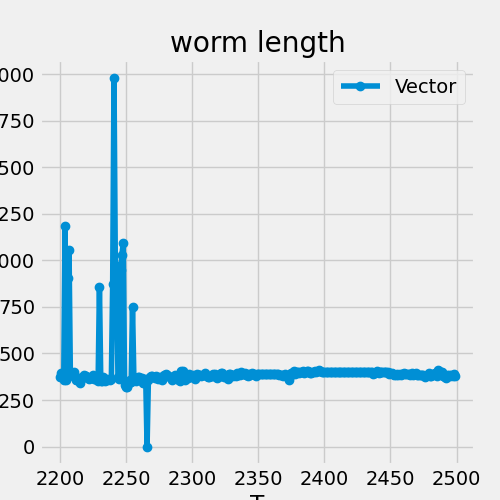

In [15]:

%matplotlib widget
# Define the interval 
start_index, end_index = 2200, 2500
# Plot the vector within the specified interval
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.plot(np.arange(start_index, end_index),lengthVec[start_index:end_index], marker='o', label='Vector')
# Add labels and title
plt.xlabel('T')
plt.ylabel('Length')
plt.title('worm length')
# Show grid
plt.grid(True)
# Add legend
plt.legend()
# Show the plot
plt.show()

In [17]:
thresh_len = 470
for t in range(6000):#len(lengthVec)):
    if lengthVec[t]>thresh_len:
        rowsArr_float2[t,:]= np.full(22, np.nan)# change 22 to 14 if you have only 7 points in the masks
    if lengthVec[t]<200:
        rowsArr_float2[t,:]= np.full(22, np.nan)# change 22 to 14 if you have only 7 points in the masks    
df_corr = pd.DataFrame(rowsArr_float2)
df_corr.to_csv(csvFile_Out+"_threshed.csv", index=False, na_rep='NaN',header=False) 

# Continue with the delay correction

## extend 11 points in original mask to 20 equidistant points

In [18]:
extended20matrix =np.zeros((len(rowsArr_float2[:,0]),40))
for t in range(len(rowsArr_float2[:,0])):
    extended20matrix[t,0::2], extended20matrix[t,1::2] = convert7to20smooth(every_second_component(rowsArr_float2[t,:],1),every_second_component(rowsArr_float2[t,:],0))


In [19]:
start_uppercam_time = 151650
fps = 4
pillar_diam = 54#diameters in pixels
pixelsize = 1000/pillar_diam #size of each pixel in tenth of micrometer
ratiox = 1/20#ratio of the upper camera pixel changes to the joystick-computed in measuring_lengths_xxx.txt file
ratioy = 1/17

## apply the delays and align masks of all the frames

In [20]:
Time0 = ['15:16:50']#start time of the upper camera recording 


T = np.shape(rowsArr_float)[0]

t1 = np.zeros((T))#vector of time points in micrpsecond unit at each frame


#location of the head in each frame
Head_XY_1 = np.zeros((2,T))


t_xy_v1 =  np.zeros((T,23))#matrix of location and time points at each frame
t_xy_v1_ext =  np.zeros((T,41))#matrix of extended point and time points at each frame

with open(joysticklog_address,'r') as f:
    lines = f.readlines()

#read the log file
f = open(joysticklog_address,'r')     
filestr = f.read()  
  
#startInd1 = filestr.index(Time0[0])
#prepare movie's time:
(h1, m1, s1) = Time0[0].split(':')
ms1 = 0
mysum1 = datetime.timedelta(hours=int(h1), minutes=int(m1), seconds=int(s1),microseconds=int(ms1))

#get time and xy location from h5 file
for t in range(int(T)):
    time = (t/fps)*10**6#corresponding time of each frame in microsceond
    t1[t] = time
#array of time at each frame  in the datetime format for the movie
t_arr1 = np.array([mysum1 + datetime.timedelta(microseconds=int(ms2)) for ms2 in t1])

for k in range(len(delaytimes)-1):
    for t in range(delaytimes[k],delaytimes[k+1]): 
        t_arr1[t] = t_arr1[t]+ Delays[k]



#initialize the matrix including datetime values for the log file
initialTimeMat = np.array([datetime.timedelta(hours=0, minutes=0, seconds=0,microseconds=0) for i in lines])
#X and Y coordinates of the X box
Xval= np.zeros(len(initialTimeMat))
Yval= np.zeros(len(initialTimeMat))

for i in range(len(lines)):
    (time,xy) = lines[i].split('  ')
    (x,y) = xy.split(' ')
    (h, m, s_tot) = time.split(':')
    (s,ms) = s_tot.split(".")
    initialTimeMat[i] = datetime.timedelta(hours=int(h), minutes=int(m), seconds=int(s),microseconds=int(ms))
    Yval[i]= y
    Xval[i]= x
ind0 = np.argmin(abs(initialTimeMat-t_arr1[0]))


Yval =  Yval- Yval[ind0]
Xval =  Xval- Xval[ind0]

log_inds = np.array([])  # Create an empty array
for k in range(len(t_arr1)):
    ind = np.argmin(abs(initialTimeMat-t_arr1[k]))# the log value that is the closest to the time point of the frame
    log_inds = np.append(log_inds,int(ind))
    t_xy_v1[k,0] = t1[k]/10**6#convert microsecond to seconds
    t_xy_v1[k,1::2] = (-Yval[ind]*ratiox+rowsArr_float2[k,0::2])#*pixelsize/10**4#convert tenth of micrometer to mm 
    t_xy_v1[k,2::2] = (-Xval[ind]*ratioy+rowsArr_float2[k,1::2])#*pixelsize/10**4 
    
    t_xy_v1_ext[k,0] = t1[k]/10**6#convert microsecond to seconds
    t_xy_v1_ext[k,1::2] = (-Yval[ind]*ratiox+extended20matrix[k,0::2])#*pixelsize/10**4#convert tenth of micrometer to mm 
    t_xy_v1_ext[k,2::2] = (-Xval[ind]*ratioy+extended20matrix[k,1::2])#*pixelsize/10**4 
print("Alignment done!")

Alignment done!


## Plot original postures without alignment for the time points between `start` and `end`.

In [39]:
start,end = 5511,5535

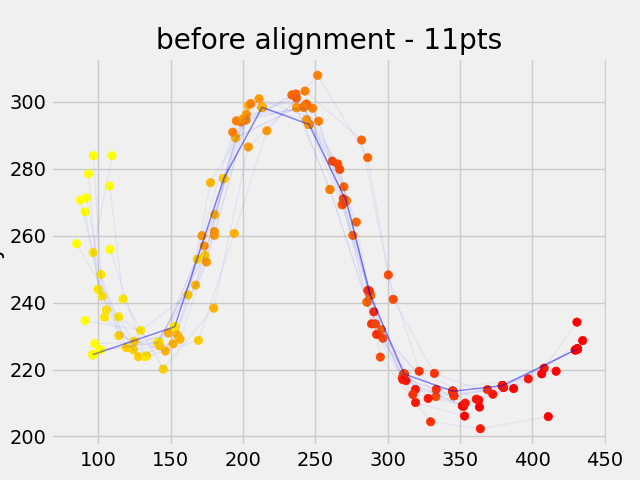

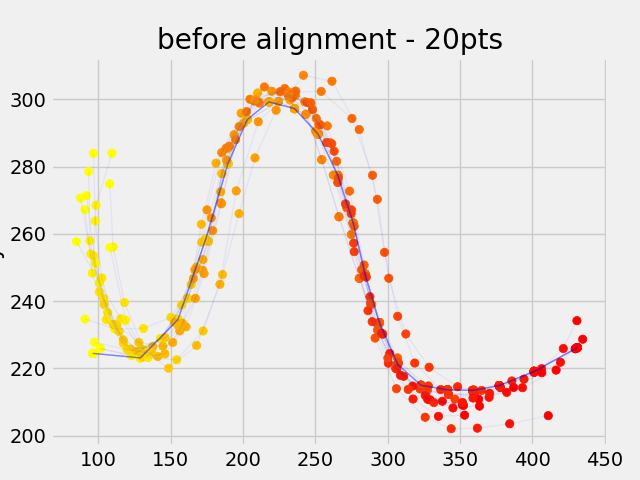

In [25]:

style.use('fivethirtyeight')

fig = plt.figure()
ax = fig.add_subplot(111)


# Create a list of colors for each segment of the line
col = np.arange(11)+20
for t in range(start,end):#np.shape(smoothed_arr)[0]):
    ax.plot(every_second_component(rowsArr_float2[t,:],1),every_second_component(rowsArr_float2[t,:],0),lw=1,
            c='b',alpha=0.05)    
    ax.scatter(every_second_component(rowsArr_float2[t,:],1),every_second_component(rowsArr_float2[t,:],0),
                   c=col,cmap='autumn')
ax.set_xlabel('x')

ax.set_ylabel('y')
ax.set_title('before alignment - 11pts')
plt.show()


style.use('fivethirtyeight')

fig = plt.figure()
ax = fig.add_subplot(111)


col = np.arange(20)
for t in range(start,end):
    ax.plot(every_second_component(extended20matrix[t,:],1),every_second_component(extended20matrix[t,:],0),lw=1,
            c='b',alpha=0.05)    
    ax.scatter(every_second_component(extended20matrix[t,:],1),every_second_component(extended20matrix[t,:],0),
                   c=col,cmap='autumn')
ax.set_xlabel('x')
ax.set_title('before alignment - 20pts')
ax.set_ylabel('y')
plt.show()

## Plot postures after alignment for the time points between `start` and `end`.

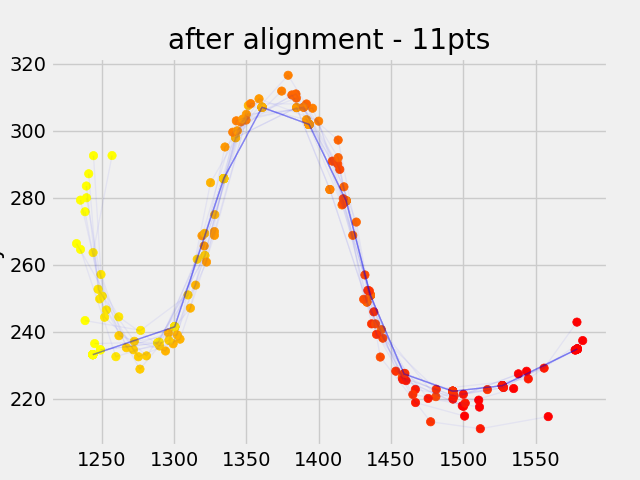

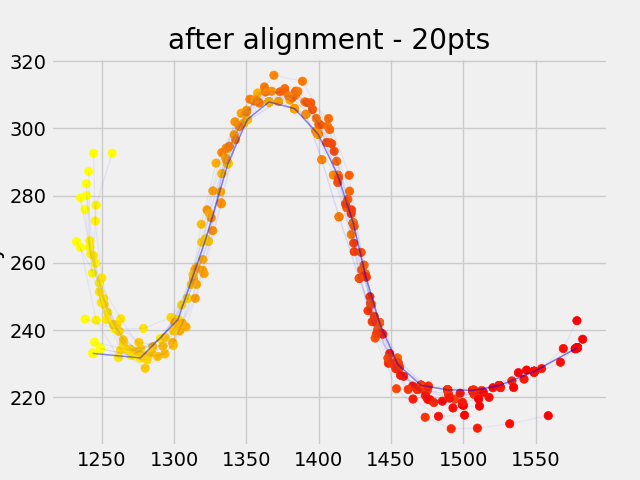

In [26]:

style.use('fivethirtyeight')

fig = plt.figure()#figsize=(25,5))
ax = fig.add_subplot(111)

# Create a list of colors for each segment of the line
col = np.arange(11)+20
for t in range(start,end):#np.shape(smoothed_arr)[0]):
    ax.plot(every_second_component(t_xy_v1[t,1:],1),every_second_component(t_xy_v1[t,1:],0),lw=1,
            c='b',alpha=0.05)    
    ax.scatter(every_second_component(t_xy_v1[t,1:],1),every_second_component(t_xy_v1[t,1:],0),
                   c=col,cmap='autumn')
ax.set_xlabel('x')
ax.set_title('after alignment - 11pts')
ax.set_ylabel('y')
plt.show()


style.use('fivethirtyeight')
# Plot the data points in 3D space with color-coded cluster assignments
fig = plt.figure()
ax = fig.add_subplot(111)

# Create a list of colors for each segment of the line
col = np.arange(20)+20
for t in range(start,end):
    ax.plot(every_second_component(t_xy_v1_ext[t,1:],1),every_second_component(t_xy_v1_ext[t,1:],0),lw=1,
            c='b',alpha=0.05)    
    ax.scatter(every_second_component(t_xy_v1_ext[t,1:],1),every_second_component(t_xy_v1_ext[t,1:],0),
                   c=col,cmap='autumn')
ax.set_xlabel('x')
ax.set_title('after alignment - 20pts')
ax.set_ylabel('y')
plt.show()

## Plot trajectories of single points before and after correction

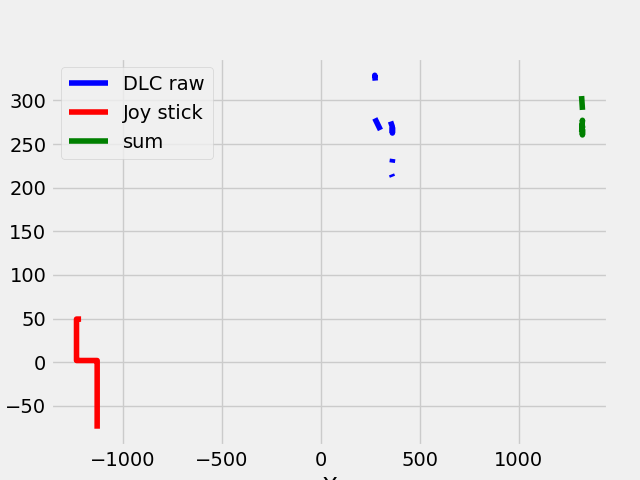

In [28]:
# Plot the trajectories in different colors
time_range = np.arange(2700,2720)
log_inds_int =[int(x) for x in log_inds[time_range]]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(rowsArr_float2[time_range,6], rowsArr_float2[time_range,7], label='DLC raw', color='blue')
ax.plot(Yval[log_inds_int]*ratioy, Xval[log_inds_int]*ratiox, label='Joy stick', color='red')
ax.plot(t_xy_v1[time_range,7], t_xy_v1[time_range,8], label='sum', color='green')

ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.legend()

plt.show()

In [29]:
log_inds_int =[int(x) for x in log_inds[time_range]]

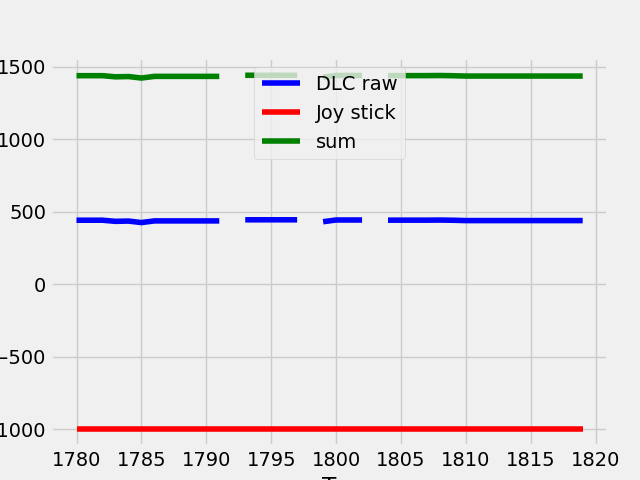

In [31]:
# Plot the trajectories in different colors
time_range = np.arange(1780,1820)
fig = plt.figure()

log_inds_int =[int(x) for x in log_inds[time_range]]
plt.plot(time_range,rowsArr_float2[time_range,0], label='DLC raw', color='blue')
plt.plot(time_range,Yval[log_inds_int]*ratiox, label='Joy stick', color='red')
plt.plot(time_range,t_xy_v1[time_range,1], label='sum', color='green')
plt.xlabel('T')
plt.ylabel('X')
plt.legend()
plt.show()

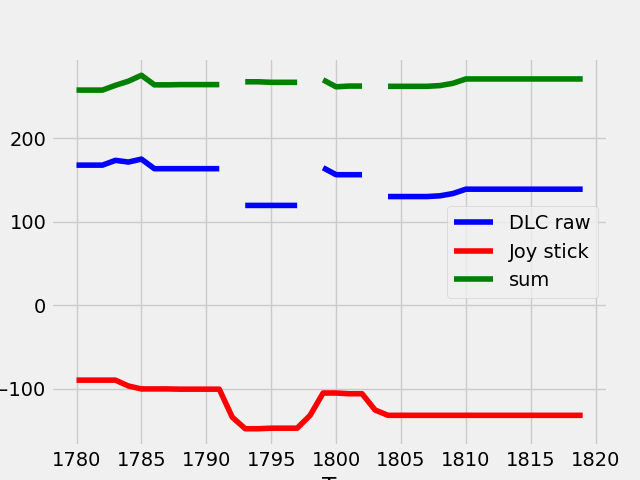

In [32]:
# Plot the trajectories in different colors

plt.figure()
log_inds_int =[int(x) for x in log_inds[time_range]]
plt.plot(time_range,rowsArr_float2[time_range,1], label='DLC raw', color='blue')
plt.plot(time_range,Xval[log_inds_int]*ratioy, label='Joy stick', color='red')
plt.plot(time_range,t_xy_v1[time_range,2], label='sum', color='green')
plt.xlabel('T')
plt.ylabel('Y')
plt.legend()
plt.show()

## Save the corrections in a separate csv file

In [37]:
#save original points after joysitck correction:
df = pd.DataFrame(t_xy_v1)
df.to_csv(csvFile_Out+"_corrected4Joystickdelays.csv", index=False, na_rep='NaN',header=False) # Assuming the file has no header
#save extended equidistant points after joysitck correction:
df2 = pd.DataFrame(t_xy_v1_ext)
df2.to_csv(csvFile_Out+"_ext_body_part_time_course_corrected_RIM.csv", index=False, na_rep='NaN',header=False) 

In [38]:
df = pd.DataFrame(t_xy_v1_ext)
csv_filename = csvFile_Out+"_ext_RIMdelayCorr_update.csv"

# Save the pandas DataFrame to a CSV file
df.to_csv(csv_filename, index=False, na_rep='NaN')